In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing
import re

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
#Defining MAPE function
def mean_absolute_percentage_error(y_true,y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

In [4]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    # Contador para ver cuantos lags hay y así poder eliminar automáticamente los atributos originales
    cont = 0
    for i in df.columns:
        cont = cont + len(re.findall("Lag*", i))
            
    df = df.drop(df.iloc[:, range((len(df.columns)-cont-1))], axis=1) # delete original attributes
    cols = list(df.columns)
    cols = cols[1:] + [cols[0]] 
    df = df[cols]
    
    return df

In [5]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE, testPredMAPE = [], [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagsco2 = np.sum([len(re.findall("Lag_co2*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagsco2], prueba_X_test.iloc[:,-lagsco2:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_co2_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        mape = mean_absolute_percentage_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        testPredMAPE.append(mape)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        print('MAPE %.2f' % (mape))
        
    return testPredRMSE, testPredMAE, testPredMAPE, preds

In [6]:
def testCO2Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['co2'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, mape, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel CO2 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de CO2')
    plt.legend()
    plt.show()
    
    return rmse, mae, mape, preds

In [7]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [8]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [9]:
ocupacion = pd.read_csv("ctcount-acces-data-RAW-2020-data.csv",
                 sep=",",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [10]:
# Para que todos los segundos sean 00
ocupacion = ocupacion.set_index(ocupacion.index.floor('T'), drop=True)

In [11]:
ocupacion['ocupacion'] = pd.to_numeric(ocupacion['numberofincoming']) - pd.to_numeric(ocupacion['numberofoutgoing'])
ocupacion

,endpoint,devicename,numberofincoming,numberofoutgoing,ocupacion
time_index,,,,,
2021-09-23 07:06:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:07:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:08:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:09:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
2021-09-23 07:10:00,HOPac67b2cd450a,urdecomaq2,2.00,2.00,0.0
...,...,...,...,...,...
2022-01-31 23:55:00,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0
2022-01-31 23:56:00,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0
2022-01-31 23:57:00,HOPac67b2cd450a,urdecomaq2,0.00,0.00,0.0


In [12]:
ocupacion.describe()

,ocupacion
count,171318.000000
mean,3.001459
std,5.581391
min,-23.000000
25%,0.000000
50%,0.000000
75%,6.000000
max,22.000000


In [13]:
ocupacion[ocupacion['ocupacion'] < 0]

,endpoint,devicename,numberofincoming,numberofoutgoing,ocupacion
time_index,,,,,
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,8.00,9.00,-1.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,9.00,10.00,-1.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,9.00,11.00,-2.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,10.00,11.00,-1.0
2021-09-23 07:55:00,HOPac67b2cd450a,urdecomaq2,10.00,12.00,-2.0
...,...,...,...,...,...
2022-01-31 22:56:00,HOPac67b2cd450a,urdecomaq2,90.00,93.00,-3.0
2022-01-31 22:57:00,HOPac67b2cd450a,urdecomaq2,90.00,93.00,-3.0
2022-01-31 22:58:00,HOPac67b2cd450a,urdecomaq2,90.00,93.00,-3.0


In [14]:
# Porcentaje de datos negativos de ocupación
14453/171318*100

8.436358117652553

In [14]:
# Los datos de presencia negativos se ponen a 0
ocupacion[ocupacion['ocupacion'] < 0] = np.nan

In [15]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72


In [16]:
df_final_ocup = df_final.join(ocupacion['ocupacion'])
df_final_ocup = df_final_ocup[['temperature', 'relativehumidity', 'ocupacion', 'pm25', 'pm10', 'co2']]

In [17]:
# NUMERO DE NA
df_final_ocup['ocupacion'].isna().sum()

1693

In [18]:
# Interpolar para rellenar los huecos
df_final_ocup = df_final_ocup.interpolate(method ='linear', limit_direction ='forward')

In [20]:
df_final_ocup.dropna(inplace=True)

# NUMERO DE NA
df_final_ocup['ocupacion'].isna().sum()

0

In [21]:
df_lags_5 = lags(df_final_ocup, 5) #predecir a 5 minutos
df_lags_5 = df_lags_5.iloc[5:,:].reset_index(drop=True)
df_lags_5

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,25.99,26.00,26.00,25.99,25.96,50.71,50.60,50.53,50.76,50.89,...,40.50,40.38,39.14,36.88,617.60,623.75,620.53,617.56,616.17,610.68
1,26.05,25.99,26.00,26.00,25.99,50.71,50.71,50.60,50.53,50.76,...,40.29,40.50,40.38,39.14,610.68,617.60,623.75,620.53,617.56,610.68
2,26.05,26.05,25.99,26.00,26.00,50.71,50.71,50.71,50.60,50.53,...,39.62,40.29,40.50,40.38,610.68,610.68,617.60,623.75,620.53,614.24
3,26.14,26.05,26.05,25.99,26.00,50.54,50.71,50.71,50.71,50.60,...,39.62,39.62,40.29,40.50,614.24,610.68,610.68,617.60,623.75,614.41
4,26.17,26.14,26.05,26.05,25.99,50.54,50.54,50.71,50.71,50.71,...,37.62,39.62,39.62,40.29,614.41,614.24,610.68,610.68,617.60,606.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17844,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,19.70,19.10,18.50,18.50,409.86,409.15,408.77,408.92,409.00,409.35
17845,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,20.10,19.70,19.10,18.50,409.35,409.86,409.15,408.77,408.92,408.84
17846,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,20.40,20.10,19.70,19.10,408.84,409.35,409.86,409.15,408.77,408.72
17847,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,20.80,20.40,20.10,19.70,408.72,408.84,409.35,409.86,409.15,408.75


In [22]:
df_lags_10 = lags(df_final_ocup, 10) #predecir a 10 minutos
df_lags_10 = df_lags_10.iloc[10:,:].reset_index(drop=True)
df_lags_10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_co2_6,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,co2
0,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,25.99,25.96,...,614.41,614.24,610.68,610.68,617.60,623.75,620.53,617.56,616.17,602.53
1,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,25.99,...,606.56,614.41,614.24,610.68,610.68,617.60,623.75,620.53,617.56,601.45
2,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,...,602.53,606.56,614.41,614.24,610.68,610.68,617.60,623.75,620.53,596.29
3,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,...,601.45,602.53,606.56,614.41,614.24,610.68,610.68,617.60,623.75,592.24
4,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,...,596.29,601.45,602.53,606.56,614.41,614.24,610.68,610.68,617.60,592.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17839,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.69,409.35
17840,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,409.20,408.84
17841,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,409.79,408.72
17842,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.84,409.35,409.86,409.15,408.77,408.92,409.00,408.89,408.49,408.75


In [23]:
df_lags_15 = lags(df_final_ocup, 15) #predecir a 15 minutos
df_lags_15 = df_lags_15.iloc[15:,:].reset_index(drop=True)
df_lags_15

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_co2_7,Lag_co2_8,Lag_co2_9,Lag_co2_10,Lag_co2_11,Lag_co2_12,Lag_co2_13,Lag_co2_14,Lag_co2_15,co2
0,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,...,614.41,614.24,610.68,610.68,617.60,623.75,620.53,617.56,616.17,587.46
1,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,...,606.56,614.41,614.24,610.68,610.68,617.60,623.75,620.53,617.56,574.65
2,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,...,602.53,606.56,614.41,614.24,610.68,610.68,617.60,623.75,620.53,565.94
3,26.29,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,...,601.45,602.53,606.56,614.41,614.24,610.68,610.68,617.60,623.75,556.34
4,26.40,26.29,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,...,596.29,601.45,602.53,606.56,614.41,614.24,610.68,610.68,617.60,545.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17834,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,408.49,409.79,409.20,408.69,408.38,408.45,408.87,409.12,409.72,409.35
17835,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.87,409.12,408.84
17836,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,409.00,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.87,408.72
17837,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,408.92,409.00,408.89,408.49,409.79,409.20,408.69,408.38,408.45,408.75


# Linear Regression

## 5 minutos

In [24]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_5 = pd.DataFrame(scaler.fit_transform(df_lags_5), columns=df_lags_5.columns)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_5.iloc[:,:-1], df_lags_norm_5.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [26]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [27]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

array([[0.13575195],
       [0.13575195],
       [0.13811308],
       ...,
       [0.00180401],
       [0.00182391],
       [0.00236777]])

In [28]:
# make predictions
trainPredict = modelLR.predict(X_train)
testPredict = modelLR.predict(X_test)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
y_train_transformed = scaler.inverse_transform(y_train.to_numpy())
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
y_test_transformed = scaler.inverse_transform(y_test.to_numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_transformed, trainPredict.ravel()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_transformed, testPredict.ravel()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.39 RMSE
Test Score: 10.28 RMSE


In [29]:
# Recursive predictions
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_5['co2'].to_numpy().reshape(-1, 1))

rmse_5, mae_5, mape_5, preds_5 = recursiveStepsAhead(X_test, y_test, 5, scaler, modelLR)

Test Score Step 1
RMSE 11.45
MAE 5.60
MAPE 52.18
Test Score Step 2
RMSE 14.52
MAE 8.22
MAPE 52.04
Test Score Step 3
RMSE 18.56
MAE 11.18
MAPE 51.89
Test Score Step 4
RMSE 22.99
MAE 14.27
MAPE 51.75
Test Score Step 5
RMSE 27.60
MAE 17.41
MAPE 51.61


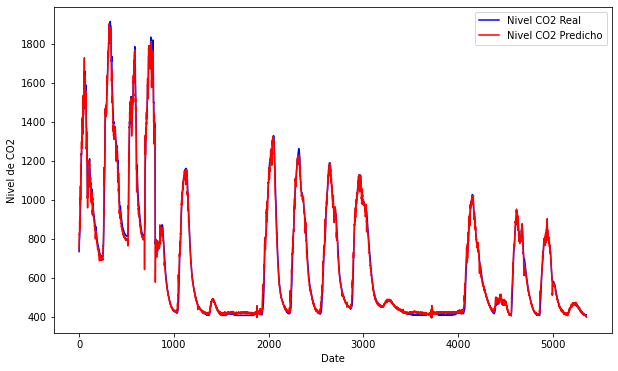

In [30]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_5[4] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

## 10 minutos

In [31]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_10 = pd.DataFrame(scaler.fit_transform(df_lags_10), columns=df_lags_10.columns)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_10.iloc[:,:-1], df_lags_norm_10.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [33]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [34]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_10['co2'].to_numpy().reshape(-1, 1))

rmse_10, mae_10, mape_10, preds_10 = recursiveStepsAhead(X_test, y_test, 10, scaler, modelLR)

Test Score Step 1
RMSE 11.77
MAE 5.74
MAPE 52.19
Test Score Step 2
RMSE 15.34
MAE 8.55
MAPE 52.05
Test Score Step 3
RMSE 19.89
MAE 11.71
MAPE 51.91
Test Score Step 4
RMSE 24.88
MAE 15.03
MAPE 51.78
Test Score Step 5
RMSE 30.08
MAE 18.42
MAPE 51.64
Test Score Step 6
RMSE 35.38
MAE 21.84
MAPE 51.51
Test Score Step 7
RMSE 40.73
MAE 25.29
MAPE 51.38
Test Score Step 8
RMSE 46.11
MAE 28.74
MAPE 51.25
Test Score Step 9
RMSE 51.51
MAE 32.18
MAPE 51.12
Test Score Step 10
RMSE 56.90
MAE 35.63
MAPE 51.00


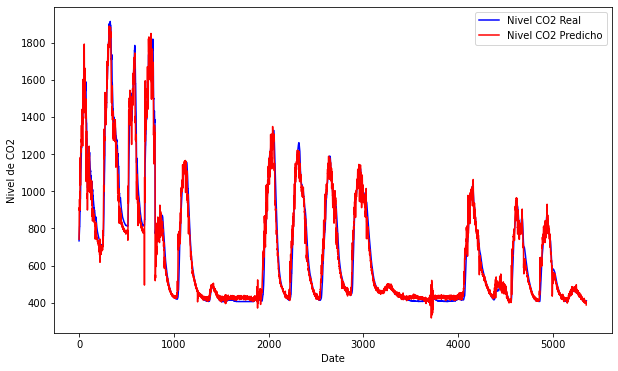

In [35]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_10[9] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

## 15 minutos

In [36]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm_15 = pd.DataFrame(scaler.fit_transform(df_lags_15), columns=df_lags_15.columns)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm_15.iloc[:,:-1], df_lags_norm_15.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [38]:
random.seed(seed)
modelLR = LinearRegression().fit(X_train, y_train)

In [39]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags_15['co2'].to_numpy().reshape(-1, 1))

rmse_15, mae_15, mape_15, preds_15 = recursiveStepsAhead(X_test, y_test, 15, scaler, modelLR)

Test Score Step 1
RMSE 11.78
MAE 5.84
MAPE 52.22
Test Score Step 2
RMSE 15.45
MAE 8.67
MAPE 52.10
Test Score Step 3
RMSE 20.13
MAE 11.82
MAPE 51.98
Test Score Step 4
RMSE 25.24
MAE 15.14
MAPE 51.86
Test Score Step 5
RMSE 30.55
MAE 18.54
MAPE 51.74
Test Score Step 6
RMSE 35.97
MAE 21.99
MAPE 51.62
Test Score Step 7
RMSE 41.46
MAE 25.48
MAPE 51.51
Test Score Step 8
RMSE 46.97
MAE 28.96
MAPE 51.40
Test Score Step 9
RMSE 52.50
MAE 32.45
MAPE 51.30
Test Score Step 10
RMSE 58.05
MAE 35.92
MAPE 51.20
Test Score Step 11
RMSE 63.58
MAE 39.37
MAPE 51.11
Test Score Step 12
RMSE 69.11
MAE 42.81
MAPE 51.03
Test Score Step 13
RMSE 74.62
MAE 46.23
MAPE 50.95
Test Score Step 14
RMSE 80.12
MAE 49.66
MAPE 50.88
Test Score Step 15
RMSE 85.59
MAE 53.07
MAPE 50.81


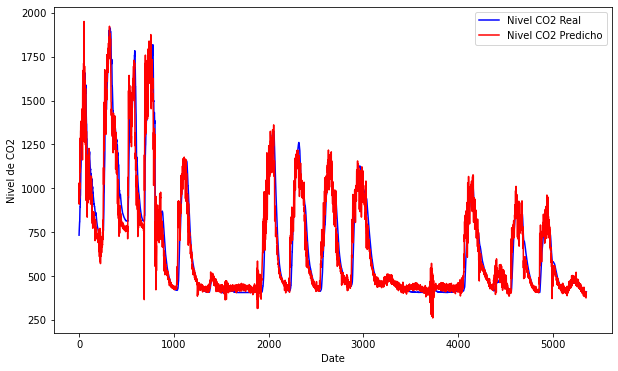

In [40]:
plt.figure(figsize=(10,6))
plt.plot(y_test_transformed, color='blue', label='Nivel CO2 Real')
plt.plot(preds_15[14] , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()

# PM2.5

In [41]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE, testPredMAPE = [], [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm25 = np.sum([len(re.findall("Lag_pm25*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm25], prueba_X_test.iloc[:,-lagspm25:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm25_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        mape = mean_absolute_percentage_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        testPredMAPE.append(mape)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        print('MAPE %.2f' % (mape))
        
    return testPredRMSE, testPredMAE, testPredMAPE, preds

In [42]:
def testPM25Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm25'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, mape, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM2.5 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM2.5 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM2.5')
    plt.legend()
    plt.show()
    
    return rmse, mae, preds

In [43]:
df_final_pm25 = df_final_ocup[['temperature', 'relativehumidity', 'ocupacion', 'pm10', 'co2', 'pm25']]

In [44]:
df_lags_5_pm25 = lags(df_final_pm25, 5) #predecir a 5 minutos
df_lags_5_pm25 = df_lags_5_pm25.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm25_1,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,pm25
0,25.99,26.00,26.00,25.99,25.96,50.71,50.60,50.53,50.76,50.89,...,623.75,620.53,617.56,616.17,38.29,38.50,38.38,37.14,34.88,37.62
1,26.05,25.99,26.00,26.00,25.99,50.71,50.71,50.60,50.53,50.76,...,617.60,623.75,620.53,617.56,37.62,38.29,38.50,38.38,37.14,37.62
2,26.05,26.05,25.99,26.00,26.00,50.71,50.71,50.71,50.60,50.53,...,610.68,617.60,623.75,620.53,37.62,37.62,38.29,38.50,38.38,35.62
3,26.14,26.05,26.05,25.99,26.00,50.54,50.71,50.71,50.71,50.60,...,610.68,610.68,617.60,623.75,35.62,37.62,37.62,38.29,38.50,34.00
4,26.17,26.14,26.05,26.05,25.99,50.54,50.54,50.71,50.71,50.71,...,614.24,610.68,610.68,617.60,34.00,35.62,37.62,37.62,38.29,31.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17844,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,409.15,408.77,408.92,409.00,19.10,18.70,18.10,17.50,17.50,19.40
17845,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,409.86,409.15,408.77,408.92,19.40,19.10,18.70,18.10,17.50,19.80
17846,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,409.35,409.86,409.15,408.77,19.80,19.40,19.10,18.70,18.10,20.80
17847,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,408.84,409.35,409.86,409.15,20.80,19.80,19.40,19.10,18.70,20.40


In [45]:
df_lags_10_pm25 = lags(df_final_pm25, 10) #predecir a 10 minutos
df_lags_10_pm25 = df_lags_10_pm25.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_2,Lag_pm25_3,Lag_pm25_4,Lag_pm25_5,Lag_pm25_6,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,pm25
0,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,25.99,25.96,...,34.00,35.62,37.62,37.62,38.29,38.50,38.38,37.14,34.88,28.00
1,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,25.99,...,31.25,34.00,35.62,37.62,37.62,38.29,38.50,38.38,37.14,26.71
2,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,...,28.00,31.25,34.00,35.62,37.62,37.62,38.29,38.50,38.38,24.50
3,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,...,26.71,28.00,31.25,34.00,35.62,37.62,37.62,38.29,38.50,22.29
4,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,...,24.50,26.71,28.00,31.25,34.00,35.62,37.62,37.62,38.29,22.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17839,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,18.70,18.10,17.50,17.50,16.80,16.30,15.80,15.80,15.10,19.40
17840,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,19.10,18.70,18.10,17.50,17.50,16.80,16.30,15.80,15.80,19.80
17841,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,19.40,19.10,18.70,18.10,17.50,17.50,16.80,16.30,15.80,20.80
17842,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,19.80,19.40,19.10,18.70,18.10,17.50,17.50,16.80,16.30,20.40


In [46]:
df_lags_15_pm25 = lags(df_final_pm25, 15) #predecir a 15 minutos
df_lags_15_pm25 = df_lags_15_pm25.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm25

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm25_7,Lag_pm25_8,Lag_pm25_9,Lag_pm25_10,Lag_pm25_11,Lag_pm25_12,Lag_pm25_13,Lag_pm25_14,Lag_pm25_15,pm25
0,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,...,34.00,35.62,37.62,37.62,38.29,38.50,38.38,37.14,34.88,20.12
1,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,...,31.25,34.00,35.62,37.62,37.62,38.29,38.50,38.38,37.14,18.62
2,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,...,28.00,31.25,34.00,35.62,37.62,37.62,38.29,38.50,38.38,16.71
3,26.29,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,...,26.71,28.00,31.25,34.00,35.62,37.62,37.62,38.29,38.50,15.75
4,26.40,26.29,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,...,24.50,26.71,28.00,31.25,34.00,35.62,37.62,37.62,38.29,14.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17834,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,16.30,15.80,15.80,15.10,14.56,14.10,13.80,13.20,13.40,19.40
17835,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,16.80,16.30,15.80,15.80,15.10,14.56,14.10,13.80,13.20,19.80
17836,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,17.50,16.80,16.30,15.80,15.80,15.10,14.56,14.10,13.80,20.80
17837,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,17.50,17.50,16.80,16.30,15.80,15.80,15.10,14.56,14.10,20.40


## Linear Regression

C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 1
RMSE 2.52
MAE 1.68
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 2
RMSE 8.63
MAE 5.73
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 3
RMSE 55.36
MAE 36.75
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 4
RMSE 298.91
MAE 198.53
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 5
RMSE 1683.16
MAE 1117.68
MAPE inf


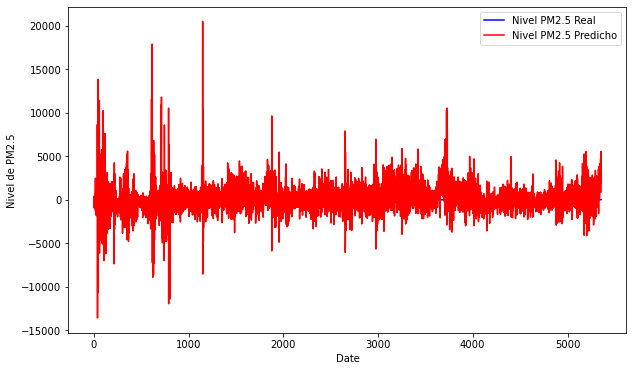

In [47]:
rmse_lr_5_pm25, mae_lr_5_pm25, preds_lr_5_pm25 = testPM25Quality(df_lags_5_pm25, 5, LinearRegression())

C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 1
RMSE 2.96
MAE 2.04
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 2
RMSE 12.77
MAE 8.79
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 3
RMSE 83.95
MAE 57.73
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 4
RMSE 502.70
MAE 345.85
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 5
RMSE 3072.94
MAE 2113.94
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 6
RMSE 18702.36
MAE 12866.02
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 7
RMSE 113925.34
MAE 78372.85
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 8
RMSE 693856.76
MAE 477326.58
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 9
RMSE 4226042.48
MAE 2907231.09
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 10
RMSE 25739197.64
MAE 17706826.07
MAPE inf


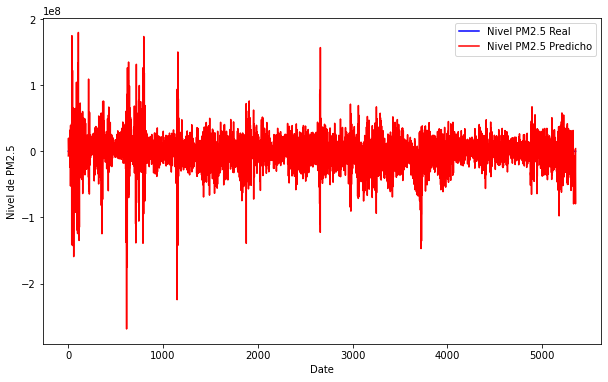

In [48]:
rmse_lr_10_pm25, mae_lr_10_pm25, preds_lr_10_pm25 = testPM25Quality(df_lags_10_pm25, 10, LinearRegression())

C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 1
RMSE 3.60
MAE 2.40
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 2
RMSE 23.04
MAE 15.14
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 3
RMSE 193.39
MAE 127.36
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 4
RMSE 1547.34
MAE 1018.77
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 5
RMSE 12488.50
MAE 8222.78
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 6
RMSE 100648.91
MAE 66269.85
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 7
RMSE 811350.24
MAE 534214.27
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 8
RMSE 6540212.50
MAE 4306247.17
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 9
RMSE 52720293.07
MAE 34712421.78
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 10
RMSE 424975007.00
MAE 279814675.01
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 11
RMSE 3425697589.66
MAE 2255569014.82
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 12
RMSE 27614338592.02
MAE 18182003770.51
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 13
RMSE 222597493873.34
MAE 146564019972.17
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 14
RMSE 1794344778189.11
MAE 1181443597280.78
MAPE inf


C:\Users\Raquel\anaconda3\envs\centic-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Test Score Step 15
RMSE 14464103468613.96
MAE 9523544550143.45
MAPE inf


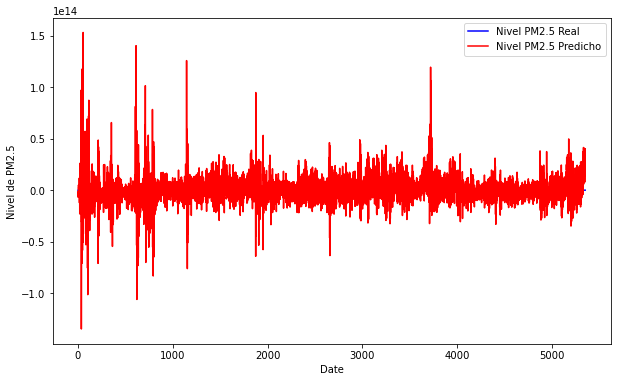

In [49]:
rmse_lr_15_pm25, mae_lr_15_pm25, preds_lr_15_pm25 = testPM25Quality(df_lags_15_pm25, 15, LinearRegression())

# PM10

In [50]:
# Realiza las prediciones recursivas a h pasos
def recursiveStepsAhead(X_test, y_test, nSteps, scaler, model):
    prueba_X_test = X_test.copy()
    testPredRMSE, testPredMAE, testPredMAPE = [], [], []
    preds = []

    testPredict = model.predict(prueba_X_test)
    lagspm10 = np.sum([len(re.findall("Lag_pm10*", i)) for i in X_test.columns])
    
    for p in range(nSteps):
        prueba_X_test = pd.concat([prueba_X_test.iloc[:,:-lagspm10], prueba_X_test.iloc[:,-lagspm10:].shift(1, axis = 1) ], axis=1)
        prueba_X_test['Lag_pm10_' + str(1)] = testPredict
        
        testPredict = model.predict(prueba_X_test)

        # invert predictions
        testPredict_transform = scaler.inverse_transform(testPredict.reshape(-1, 1))
        y_test_transform = scaler.inverse_transform(y_test.to_numpy())

        # calculate root mean squared error
        rmse = math.sqrt(mean_squared_error(y_test_transform, testPredict_transform.ravel()))
        mae = mean_absolute_error(y_test_transform, testPredict_transform.ravel())
        mape = mean_absolute_percentage_error(y_test_transform, testPredict_transform.ravel())
        
        testPredRMSE.append(rmse)
        testPredMAE.append(mae)
        testPredMAPE.append(mape)
        
        preds.append(testPredict_transform)
        print('Test Score Step %d' % (p+1))
        print('RMSE %.2f' % (rmse))
        print('MAE %.2f' % (mae))
        print('MAE %.2f' % (mape))
        
    return testPredRMSE, testPredMAE, testPredMAPE, preds

In [51]:
def testPM10Quality(df, nSteps, model):
    # normalize the dataset
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    X_train, X_test, y_train, y_test = train_test_split(df_norm.iloc[:,:-1], df_norm.iloc[:,-1:], 
                                                        test_size=0.3, 
                                                        random_state=seed_value,
                                                       shuffle=False)

    # train the model
    random.seed(seed)
    model = model.fit(X_train, y_train.to_numpy().ravel())

    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit_transform(df['pm10'].to_numpy().reshape(-1, 1))

    # recursive steps ahead predictions
    rmse, mae, mape, preds = recursiveStepsAhead(X_test, y_test, nSteps, scaler, model)
    
    y_test_transformed = scaler.inverse_transform(y_test.to_numpy())
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.plot(y_test_transformed, color='blue', label='Nivel PM10 Real')
    plt.plot(preds[nSteps-1] , color='red', label='Nivel PM10 Predicho')
    plt.xlabel('Date')
    plt.ylabel('Nivel de PM10')
    plt.legend()
    plt.show()
    
    return rmse, mae, mape, preds

In [52]:
df_final_pm10 = df_final_ocup[['temperature', 'relativehumidity', 'ocupacion', 'pm25', 'co2', 'pm10']]

In [53]:
df_lags_5_pm10 = lags(df_final_pm10, 5) #predecir a 5 minutos
df_lags_5_pm10 = df_lags_5_pm10.iloc[5:,:].reset_index(drop=True)
df_lags_5_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,Lag_pm10_1,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,pm10
0,25.99,26.00,26.00,25.99,25.96,50.71,50.60,50.53,50.76,50.89,...,623.75,620.53,617.56,616.17,40.29,40.50,40.38,39.14,36.88,39.62
1,26.05,25.99,26.00,26.00,25.99,50.71,50.71,50.60,50.53,50.76,...,617.60,623.75,620.53,617.56,39.62,40.29,40.50,40.38,39.14,39.62
2,26.05,26.05,25.99,26.00,26.00,50.71,50.71,50.71,50.60,50.53,...,610.68,617.60,623.75,620.53,39.62,39.62,40.29,40.50,40.38,37.62
3,26.14,26.05,26.05,25.99,26.00,50.54,50.71,50.71,50.71,50.60,...,610.68,610.68,617.60,623.75,37.62,39.62,39.62,40.29,40.50,36.00
4,26.17,26.14,26.05,26.05,25.99,50.54,50.54,50.71,50.71,50.71,...,614.24,610.68,610.68,617.60,36.00,37.62,39.62,39.62,40.29,33.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17844,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,409.15,408.77,408.92,409.00,20.10,19.70,19.10,18.50,18.50,20.40
17845,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,409.86,409.15,408.77,408.92,20.40,20.10,19.70,19.10,18.50,20.80
17846,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,409.35,409.86,409.15,408.77,20.80,20.40,20.10,19.70,19.10,21.80
17847,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,408.84,409.35,409.86,409.15,21.80,20.80,20.40,20.10,19.70,21.40


In [54]:
df_lags_10_pm10 = lags(df_final_pm10, 10) #predecir a 10 minutos
df_lags_10_pm10 = df_lags_10_pm10.iloc[10:,:].reset_index(drop=True)
df_lags_10_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_pm10_6,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,pm10
0,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,25.99,25.96,...,36.00,37.62,39.62,39.62,40.29,40.50,40.38,39.14,36.88,30.00
1,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,25.99,...,33.25,36.00,37.62,39.62,39.62,40.29,40.50,40.38,39.14,28.71
2,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,26.00,...,30.00,33.25,36.00,37.62,39.62,39.62,40.29,40.50,40.38,25.88
3,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,26.00,...,28.71,30.00,33.25,36.00,37.62,39.62,39.62,40.29,40.50,23.29
4,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,25.99,...,25.88,28.71,30.00,33.25,36.00,37.62,39.62,39.62,40.29,23.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17839,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,19.70,19.10,18.50,18.50,17.80,17.30,16.80,16.80,16.10,20.40
17840,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,20.10,19.70,19.10,18.50,18.50,17.80,17.30,16.80,16.80,20.80
17841,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,20.40,20.10,19.70,19.10,18.50,18.50,17.80,17.30,16.80,21.80
17842,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,20.80,20.40,20.10,19.70,19.10,18.50,18.50,17.80,17.30,21.40


In [55]:
df_lags_15_pm10 = lags(df_final_pm10, 15) #predecir a 15 minutos
df_lags_15_pm10 = df_lags_15_pm10.iloc[15:,:].reset_index(drop=True)
df_lags_15_pm10

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_temperature_6,Lag_temperature_7,Lag_temperature_8,Lag_temperature_9,Lag_temperature_10,...,Lag_pm10_7,Lag_pm10_8,Lag_pm10_9,Lag_pm10_10,Lag_pm10_11,Lag_pm10_12,Lag_pm10_13,Lag_pm10_14,Lag_pm10_15,pm10
0,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,26.05,...,36.00,37.62,39.62,39.62,40.29,40.50,40.38,39.14,36.88,21.12
1,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,26.05,...,33.25,36.00,37.62,39.62,39.62,40.29,40.50,40.38,39.14,19.62
2,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,26.14,...,30.00,33.25,36.00,37.62,39.62,39.62,40.29,40.50,40.38,17.71
3,26.29,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,26.17,...,28.71,30.00,33.25,36.00,37.62,39.62,39.62,40.29,40.50,16.75
4,26.40,26.29,26.29,26.24,26.24,26.24,26.18,26.17,26.17,26.22,...,25.88,28.71,30.00,33.25,36.00,37.62,39.62,39.62,40.29,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17834,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,18.91,...,17.30,16.80,16.80,16.10,15.56,15.10,14.80,14.20,14.40,20.40
17835,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,18.87,...,17.80,17.30,16.80,16.80,16.10,15.56,15.10,14.80,14.20,20.80
17836,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,18.90,...,18.50,17.80,17.30,16.80,16.80,16.10,15.56,15.10,14.80,21.80
17837,18.78,18.82,18.81,18.82,18.82,18.83,18.86,18.87,18.86,18.87,...,18.50,18.50,17.80,17.30,16.80,16.80,16.10,15.56,15.10,21.40


## Linear Regression

Test Score Step 1
RMSE 2.49
MAE 1.65
MAE 81.87
Test Score Step 2
RMSE 18.83
MAE 12.48
MAE 279.54
Test Score Step 3
RMSE 112.16
MAE 74.23
MAE 1703.73
Test Score Step 4
RMSE 629.00
MAE 416.09
MAE 9645.77
Test Score Step 5
RMSE 3473.37
MAE 2297.31
MAE 53357.67


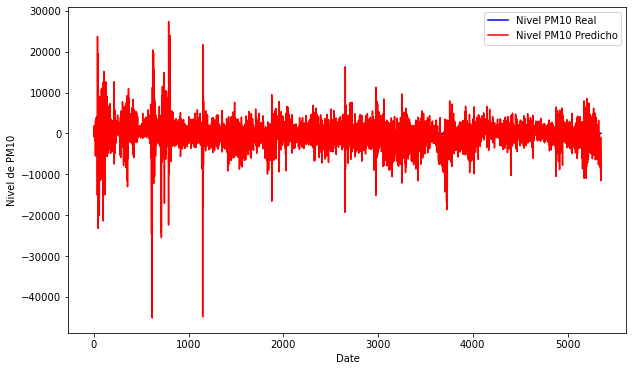

In [56]:
rmse_lr_5_pm10, mae_lr_5_pm10, mape_lr_5_pm10, preds_lr_5_pm10 = testPM10Quality(df_lags_5_pm10, 5, LinearRegression())

Test Score Step 1
RMSE 3.01
MAE 2.05
MAE 87.90
Test Score Step 2
RMSE 23.83
MAE 16.28
MAE 369.48
Test Score Step 3
RMSE 155.08
MAE 105.82
MAE 2441.34
Test Score Step 4
RMSE 969.55
MAE 661.37
MAE 15342.21
Test Score Step 5
RMSE 6008.61
MAE 4098.46
MAE 95168.00
Test Score Step 6
RMSE 37164.36
MAE 25349.32
MAE 588715.56
Test Score Step 7
RMSE 229774.15
MAE 156725.34
MAE 3639901.35
Test Score Step 8
RMSE 1420497.49
MAE 968898.21
MAE 22502478.32
Test Score Step 9
RMSE 8781579.66
MAE 5989771.48
MAE 139111408.18
Test Score Step 10
RMSE 54287941.07
MAE 37028913.07
MAE 859990204.61


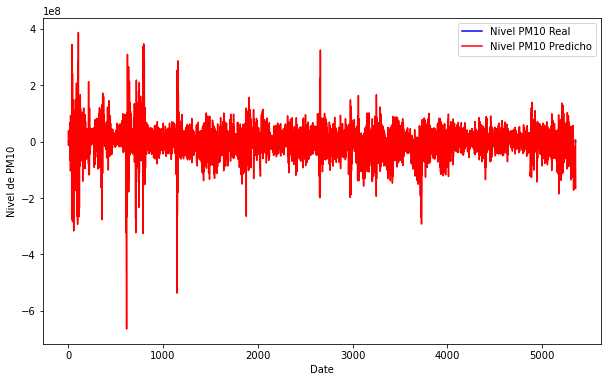

In [57]:
rmse_lr_10_pm10, mae_lr_10_pm10, mape_lr_10_pm10, preds_lr_10_pm10 = testPM10Quality(df_lags_10_pm10, 10, LinearRegression())

Test Score Step 1
RMSE 3.75
MAE 2.42
MAE 91.79
Test Score Step 2
RMSE 36.95
MAE 24.13
MAE 549.44
Test Score Step 3
RMSE 314.78
MAE 205.68
MAE 4756.66
Test Score Step 4
RMSE 2614.47
MAE 1708.40
MAE 39629.27
Test Score Step 5
RMSE 21614.67
MAE 14124.04
MAE 327756.51
Test Score Step 6
RMSE 178553.48
MAE 116675.19
MAE 2707642.40
Test Score Step 7
RMSE 1474796.21
MAE 963700.68
MAE 22364407.82
Test Score Step 8
RMSE 12181107.63
MAE 7959703.99
MAE 184719376.06
Test Score Step 9
RMSE 100609762.35
MAE 65743111.91
MAE 1525688346.84
Test Score Step 10
RMSE 830985108.76
MAE 543004432.82
MAE 12601404462.74
Test Score Step 11
RMSE 6863510848.86
MAE 4484938148.34
MAE 104081138661.67
Test Score Step 12
RMSE 56689079131.30
MAE 37043288658.22
MAE 859656819417.57
Test Score Step 13
RMSE 468222715367.74
MAE 305958563226.06
MAE 7100324373679.54
Test Score Step 14
RMSE 3867279456317.35
MAE 2527060792252.15
MAE 58645037248978.70
Test Score Step 15
RMSE 31941744605101.54
MAE 20872225899221.51
MAE 484377925961

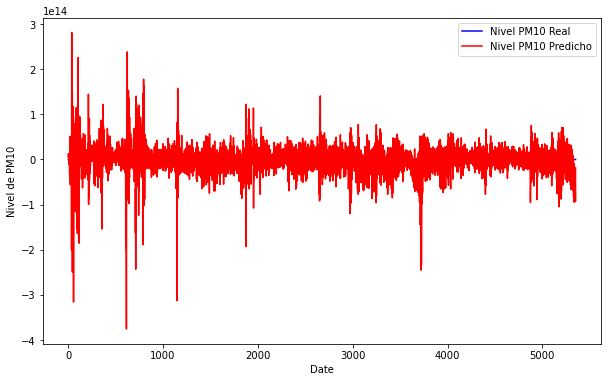

In [58]:
rmse_lr_15_pm10, mae_lr_15_pm10, mape_lr_15_pm10, preds_lr_15_pm10 = testPM10Quality(df_lags_15_pm10, 15, LinearRegression())